I recently got familiar with the Apple ecosystem due to receiving a new iPhone from my mom. (Thanks, mom!)  I have had a MacBook Pro since college and now have an iPhone to seamlessly do tasks together. So watching Apple's latest WWDC 2024 was only the next best thing in order to keep track their newest offerings. 

Goal: NLP/Sentiment Analysis on WWDC 2024 - what people liked, what were the most talked about releases, etc.

Performing this analysis will provide insight on how Apple is still in the game since people have been seeing it as behind on the AI front.

In [1]:
!pip install pyabsa --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.11 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
# Aspect Based Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyabsa import ATEPCCheckpointManager

2024-07-07 01:22:06.006414: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 01:22:06.006548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 01:22:06.172399: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/bin/sh: 1: nvidia-smi: not found


No CUDA GPU found in your device
[2024-07-07 01:22:22] (2.4.1.post1) PyABSA(2.4.1.post1): If your code crashes on Colab, please use the GPU runtime. Then run "pip install pyabsa[dev] -U" and restart the kernel.
Or if it does not work, you can use v1.x versions, e.g., pip install pyabsa<2.0 -U




Try to downgrade transformers<=4.29.0.






In [3]:
!pip install praw duckdb jupysql bertopic groq pyabsa --quiet

/opt/conda/lib/python3.10/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.Pool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


In [4]:
import os
from pprint import pprint

# math
from math import *
import math

# API's
import googleapiclient.discovery #YouTube
import googleapiclient.errors
import praw # Reddit
from praw.models import MoreComments
from kaggle_secrets import UserSecretsClient

# Data Manipulations
import re
import numpy as np 
import pandas as pd
pd.set_option('display.max_colwidth', None)
import json
from datetime import datetime 

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

import duckdb
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb

# Visualization
import matplotlib.pyplot as plt 

## Generate different embeddings
import tensorflow
import tensorflow_hub as hub

# Topic Modeling
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance

from sklearn.feature_extraction.text import CountVectorizer

# Fast Language Model Inference
from groq import Groq

# Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Aspect Based Sentiment Analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyabsa import ATEPCCheckpointManager

/opt/conda/lib/python3.10/site-packages/nltk/decorators.py:69: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  signature = inspect.formatargspec(regargs, varargs, varkwargs, defaults,


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Deploy Dash apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


/opt/conda/lib/python3.10/site-packages/tensorflow_hub/__init__.py:61: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/opt/conda/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/opt/conda/lib/python3.10/site-packages/pkg_resources/__init__.py:2868: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  d

# Get the data (YouTube and Reddit)
If there is not enough data, augment data with synonyms

API Links:
* [YouTube](https://console.cloud.google.com/apis/credentials?project=festive-zoo-404500)
* [Reddit](https://ssl.reddit.com/prefs/apps/)

YouTube Videos:
1. https://www.youtube.com/watch?v=qkYoBNdcXBU
1. https://www.youtube.com/watch?v=p2dhZ3AoDDs


Reddit Sub's:
1. https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/
1. https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/
1. https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/

In [5]:
user_secrets = UserSecretsClient()

In [6]:
# YouTube credentials
api_service_name = "youtube"
api_version = "v3"
DEVELOPER_KEY = user_secrets.get_secret("youtube_apikey")

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=DEVELOPER_KEY)

In [7]:
def getcomments(video):
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video,
        maxResults=100
    )

    comments = []

    response = request.execute()

    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']
        comments.append([
            comment['authorDisplayName'],
            comment['publishedAt'],
            comment['likeCount'],
            comment['textOriginal'],
            comment['videoId']
        ])

    while (1 == 1):
        try:
            nextPageToken = response['nextPageToken']
        except KeyError:
            break
        nextPageToken = response['nextPageToken']
        # Create a new request object with the next page token.
        nextRequest = youtube.commentThreads().list(part="snippet", videoId=video, maxResults=100, pageToken=nextPageToken)
        # Execute the next request.
        response = nextRequest.execute()
        # Get the comments from the next response.
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            published_at = comment['publishedAt']
            comments.append([
                comment['authorDisplayName'],
                published_at,
                comment['likeCount'],
                comment['textOriginal'],
                comment['videoId']
            ])

    df0 = pd.DataFrame(comments, columns = ['author', 'published_at', 'like_count', 'text', 'video_id'])
    return df0

In [8]:
# Get all WWDC 2024 comments from YouTube

# vids = [MKBHD, Vox]
vids = ["qkYoBNdcXBU", "p2dhZ3AoDDs"]

df0 = pd.DataFrame()

for v in vids:
    df1 = getcomments(v)
    df0 = pd.concat([df0, df1]) # Combine all df's together into one big dataframe

df0.sample(5)

,author,published_at,like_count,text,video_id
3716,@euxitheos_,2024-06-11T17:15:38Z,0,When will Apple improve indoor walking tracking accuracy on non-motorized treadmills in the Fitness app?,qkYoBNdcXBU
8893,@aithwndr,2024-06-11T08:03:23Z,0,Casually takin notes in a Samsung and using it. Real smooth Marques.,qkYoBNdcXBU
4799,@c_3ax,2024-06-11T14:34:38Z,0,awesome and concise recap as always :),qkYoBNdcXBU
376,@fusemunk,2024-06-10T20:26:49Z,0,"This is pish, end of!! Whopeee pi dooo",p2dhZ3AoDDs
8191,@TheBigNegative-PhotoChannel,2024-06-11T08:42:13Z,1,A new password app is nice but the icloud app for windows is absolute trash i can't connect to the service for least a full year because the authentification is broken. Worst app Apple ever made.,qkYoBNdcXBU


In [9]:
# Proper date formats
df0['published_at'] = pd.to_datetime(df0['published_at'], format='%Y-%m-%dT%H:%M:%SZ')
df0['published_at_date'] = df0['published_at'].dt.date
df0['published_at_month'] = df0['published_at'].dt.month

In [10]:
# Rename video id's to appropriate video maker
df0['video_id'] = df0['video_id'].map({'qkYoBNdcXBU' : 'MKBHD', 'p2dhZ3AoDDs' : 'The Verge'})
df0.rename(columns = {'video_id':'youtube_channel'}, inplace=True)
df0.sample(5)

,author,published_at,like_count,text,youtube_channel,published_at_date,published_at_month
4314,@gg1ad435,2024-06-11 15:48:09,0,When it comes to the AI we normal iPhone 15 users played ourselves 🤦🏾‍♂️,MKBHD,2024-06-11,6
4316,@ehyojono,2024-06-11 15:47:58,0,"With gen-emoji, can we now make an eggplant filling a donut hole?",MKBHD,2024-06-11,6
9670,@satyamkalgude3902,2024-06-11 07:29:37,0,"208 comments under a minute, this guy literally blew up",MKBHD,2024-06-11,6
1825,@TechOut,2024-06-12 04:48:43,0,Has 19 million subs but still gotta drop the make sure you subscribe when talking about upcoming videos 😂,MKBHD,2024-06-12,6
822,@SeattleNoname,2024-06-13 07:08:34,2,Apple AI is not AI at all. As always Apple delivers a garbage!,MKBHD,2024-06-13,6


In [11]:
df0['youtube_channel'].value_counts()

youtube_channel
MKBHD        9840
The Verge     483
Name: count, dtype: int64

In [12]:
df0['app'] = 'YouTube'

In [13]:
len(df0)

10323

In [14]:
# Reddit credentials
reddit = praw.Reddit(client_id=user_secrets.get_secret("reddit_client_id"),
                     client_secret=user_secrets.get_secret("reddit_client_secret"),
                     user_agent=user_secrets.get_secret("reddit_user_agent"))

In [15]:
# get all-level Reddit comments for all Reddit posts
def reddit_comments(url):

    all_level_comments = []

    submission = reddit.submission(url=url)

    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        published_at = str(datetime.fromtimestamp(comment.created)) #UTC
        published_at = pd.to_datetime(published_at, format='%Y-%m-%d %H:%M:%S')
        all_level_comments.append({
            "author": comment.author,
            "published_at": published_at, 
            "published_at_date": published_at.date(),
            "published_at_month": published_at.month,
            "like_count": comment.score,
            "text": comment.body
        })

    all_comments_df = pd.DataFrame(all_level_comments)
    return all_comments_df

In [16]:
# Define function to get dataframe for all Reddit comments
def combo_dataframe(links):
    df = pd.DataFrame()
   
    for l in links:
        df2 = reddit_comments(l)
        df = pd.concat([df, df2]) # Combine all df's together into one big dataframe
    return df

In [17]:
# get WWDC 2024 posts' all-level Reddit comments

reddit_links = ['https://www.reddit.com/r/apple/comments/1dct23m/wwdc_2024_postevent_megathread/',
                 'https://www.reddit.com/r/iOSProgramming/comments/1dcmmsm/wwdc_2024_megathread/',
                 'https://www.reddit.com/r/apple/comments/1de4qkn/what_are_your_biggest_takeaways_from_wwdc_2024_so/'] 

reddit_df = combo_dataframe(reddit_links)

In [18]:
reddit_df.head()

author        published_at published_at_date  \
0          BCDragon3000 2024-06-10 18:45:13        2024-06-10   
1            Oulixonder 2024-06-10 18:45:23        2024-06-10   
2       hammerheadtiger 2024-06-10 18:44:49        2024-06-10   
3  ConflictedRedbird186 2024-06-10 18:45:04        2024-06-10   
4       BeefIsForDinner 2024-06-10 18:44:24        2024-06-10   

   published_at_month  like_count  \
0                   6         814   
1                   6         529   
2                   6         876   
3                   6         136   
4                   6          92   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [19]:
len(reddit_df)

1344

In [20]:
reddit_df['app'] = 'Reddit'

In [21]:
# Before concating YouTube and Reddit df's. see if their columns are equal.
list(reddit_df)

['author',
 'published_at',
 'published_at_date',
 'published_at_month',
 'like_count',
 'text',
 'app']

In [22]:
youtube_df = df0.drop(columns=['youtube_channel'], inplace=True)
youtube_df = df0

In [23]:
list(youtube_df)

['author',
 'published_at',
 'like_count',
 'text',
 'published_at_date',
 'published_at_month',
 'app']

In [24]:
# Combine YouTube df and Reddit df together
df = pd.concat([youtube_df, reddit_df])
len(df)

11667

In [25]:
df.head()

,author,published_at,like_count,text,published_at_date,published_at_month,app
0,@zancaredler,2024-07-07 00:32:48,0,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,2024-07-07,7,YouTube
1,@osamaink,2024-07-06 13:33:49,0,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,2024-07-06,7,YouTube
2,@stearshetfield,2024-07-06 12:58:14,0,I love kislux that on the butterfly bag it says auguri / tanti auguri which means happy birthday,2024-07-06,7,YouTube
3,@igorteller1516,2024-07-06 11:09:45,0,"The most important question, at least for me, is if you have built-in recording software inside the phone, If I understand correctly, there will be an addition of an option, but what happens if I want to record a phone that is Android, After all, when I start recording the conversation, the person will be aware of it by an automatic notification from my iPhone that I'm recording it, but what happens with Android, he won't receive any notifications, probably about it, and if at all I can record him?",2024-07-06,7,YouTube
4,@Ragduff598,2024-07-05 15:29:19,0,People of the next generations are going to be so dumb lol,2024-07-05,7,YouTube


# With only 12,000 samples, augment data using synonyms?

# Perform Bertopic Modeling

In [26]:
# No text pre-processing needed
docs = df['text']

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words # Diversify topic words
  calculate_probabilities=True,        
  verbose=True,
  representation_model=representation_model
)

topics, probs = topic_model.fit_transform(docs)
topic_model.get_topic_info()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-07-07 01:25:06,795 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/365 [00:00<?, ?it/s]

2024-07-07 01:26:41,288 - BERTopic - Embedding - Completed ✓
2024-07-07 01:26:41,290 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-07 01:27:16,928 - BERTopic - Dimensionality - Completed ✓
2024-07-07 01:27:16,930 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-07 01:27:26,345 - BERTopic - Cluster - Completed ✓
2024-07-07 01:27:26,355 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-07 01:27:45,538 - BERTopic - Representation - Completed ✓


Topic  Count                                 Name  \
0       -1   2961            -1_ai_apple_like_features   
1        0   1002  0_calculator_ipad_handwriting_maths   
2        1    381           1_mkbhd_notes_galaxy_event   
3        2    261           2_ai_tech_times_definition   
4        3    252      3_apple_catch_products_innovate   
..     ...    ...                                  ...   
120    119     18               119_fantasic_yay_time_   
121    120     17       120_gemini_bard_sirir_thescore   
122    121     16      121_remote_shareplay_mac_access   
123    122     16  122_tracking_segues_waveform_tiktok   
124    123     16             123_type_siri_button_bar   

                                                                              Representation  \
0                         [ai, apple, like, features, siri, video, ios, icons, apps, phones]   
1        [calculator, ipad, handwriting, maths, note, students, high, pencil, homework, lol]   
2                     [mkbhd, notes, galaxy, event, updates, reads, lol, ios, device, ultra]   
3                    [ai, tech, times, definition, ml, did, investors, beta, think, entropy]   
4      [apple, catch, products, innovate, tech, customers, years, ideas, gimmicks, pathetic]   
..                                                                                       ...   
120                                                      [fantasic, yay, time, , , , , , , ]   
121           [gemini, bard, sirir, thescore, chatgpt, mails, denies, 911, midjourney, nano]   
122         [remote, shareplay, mac, access, trainer, msp, distance, ipad, fyi, controlling]   
123  [tracking, segues, waveform, tiktok, adjust, lit, visionos, eyes, swipe, accessibility]   
124          [type, siri, button, bar, accesibility, replay, 29, able, advertised, versions]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

* The first topic is -1 and contains the most records. This is the outliers topic and should typically be ignored during analysis.

Let's see if different embeddings create more clear topics.


In [27]:
%%time

#load the universal sentence encoder model
use4 = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#generate embeddings
use4_embeddings = use4(df['text'])
use= np.array(use4_embeddings)

#create list from np arrays to store the embeddings in the dataframe
df['use4'] = use.tolist()

#pass the embeddings into BERTopic
topic_model.fit_transform(docs, use)

#get topic info
topic_model.get_topic_info()

2024-07-07 01:28:43,214 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-07 01:28:52,432 - BERTopic - Dimensionality - Completed ✓
2024-07-07 01:28:52,434 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-07 01:28:59,611 - BERTopic - Cluster - Completed ✓
2024-07-07 01:28:59,618 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-07 01:29:15,783 - BERTopic - Representation - Completed ✓


CPU times: user 1min 40s, sys: 24.4 s, total: 2min 4s
Wall time: 1min 30s


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4679,-1_apple_ai_features_just,"[apple, ai, features, just, years, ios, apps, calculator, thing, video]","[My takeaway was that across MacOS, iOS and iPadOS I found very few things that I could tell I would include in my daily use.\n\nI already use 1Password so Apple Passwords is not useful for me. I can already do corner splits with BetterTouchTool's snap functions. \n\nI could have used something like improvements to MacOS virtual desktop handling instead, e.g naming desktops, arranging them in some other manner than a horizontal line, separating desktops vs fullscreen apps etc. It's one feature I use every day that is woefully forgotten by Apple. And Microsoft for that matter!\n\nI just shipped off my 2017 iPad Pro 12.9"" in a trade-in for a Samsung Galaxy Tab S9+ 12.4"". That way I got most of what the 2024 iPad Pro 12.9"" offers at about 1/3 of the cost thanks to steep sales + trade-in value. The S9+ 16:10 format is not ideal, but it is more compact than the old iPad Pro. \n\nThis came at a good time right when Apple announced my iPad Pro would not have gotten iOS 18 anyway. Not that it matters much, because there were exactly zero features showcased that made me go ""I want that!""\n\nI already moved away from iOS to the Samsung Galaxy Fold 4. With the discontinuation of the iPhone Mini line, I was left to pick from what I wanted to get away from - phones larger than I'd like! I like the Fold because when folded it is similar width to the iPhone 12 Mini I was using, obviously just taller, heavier and much thicker. It has not been the most reliable phone, but when it works I really do love the foldable thing and Apple has nothing like that in their lineup. \n\nApple is facing a dilemma where they make great hardware, but then have very few incentives for people to upgrade. I could easily be using something as old as the iPhone XS and not feel like I'm getting a lesser experience vs the latest and greatest iPhone Pro unless I'm really into photography. Great for a consumer, but not good business. We have gone from ""worth upgrading every 1-2 years"" to ""why bother upgrading if it still works"" as phone/tablet costs have crept up to very pricy levels.\n\nSoftwarewise, Samsung OneUI allows so many things that finetune its features to my liking, so it feels more like I can make it mine instead of adapting to what Apple thinks is good. I'm not talking about launchers or widgets here, but just a variety of toggles that alter how its vast array of features works.\n\nSo, I'm out, except for Mac., Apple finally can move their icons anywhere and people think it's something great like Samsung didn't have it 10 years ago 😭😭😭, These are not new features, been on android for years.]"
1,0,662,0_samsung_s24_notes_marques,"[samsung, s24, notes, marques, read, mkbhd, updates, funny, ios, savage]","[Reading from your Samsung, Reading notes of a Samsung.., As Marques is reading his notes of a Samsung Ultra. 😂]"
2,1,573,1_siri_type_accessibility_settings,"[siri, type, accessibility, settings, voice, chatgpt, bixby, languages, button, homepods]","[You could already type to Siri 😘, What have they done to Siri..., AI as in Siri?]"
3,2,311,2_apple_catch_boring_monopoly,"[apple, catch, boring, monopoly, age, companies, innovation, things, finally, sequoia]","[At this point its obvious apple is simply playing catch up. Nothing about apple is new.., well done Apple!, Only apple can do...]"
4,3,301,3_icons_homescreen_ugly_dark,"[icons, homescreen, ugly, dark, tint, apps, colors, widgets, themes, customize]","[Man. I'm excited about AI baked into iOS for sure. I was hoping to see them talk about iOS keyboard improvements tho. Hopefully ChatGPT is used to make their swipe text prediction better, because it's absolutely horrible. Also..... how in 2024 do we not have a GD MF'N NUMBER ROW??? I'm over this shit. I have to use Swiftkey because it's that important of a keyboard feature for me. \n\nTh

In [28]:
topic_model.get_topic(0) # top topic

[('samsung', 0.09683716608405164),
 ('s24', 0.0531516807531434),
 ('notes', 0.03788532474364849),
 ('marques', 0.03107020859339091),
 ('read', 0.030418427547770827),
 ('mkbhd', 0.02956542013243397),
 ('updates', 0.019878080486263612),
 ('funny', 0.015001765186050111),
 ('ios', 0.013412573224970676),
 ('savage', 0.011227857028144493)]

These topics seem more interpretable due to better embeddings.

#### BERTopic Visualizations 
Reference: https://maartengr.github.io/BERTopic/getting_started/visualization/visualization.html#visualize-probablities-or-distribution

In [29]:
topic_model.visualize_topics()

The biggest topic after the outlier topic (0) was topic 1 which was about Siri. I used the slider to highlight the bubble. When you hover over the bubble, you see the words associated with the topic.

In [30]:
topic_model.visualize_barchart(top_n_topics=8)

Looks like some other huge topics were criticism of Apple being behind in development including the AI frontier. Though a huge win was the showcasing of the interactive/predictive calculator.

In [31]:
topic_model.visualize_heatmap()

# Perform Sentiment and Emotion Classification

* Not sure what the benchmark is for good separation between topics. 
* Considering topics not along the diagonal and not associated with topic 0.  
* Most topics are 0.4 or below in similarity score. This means there are nice distinct topics discovered under better embeddings and BERTopic model.

In [32]:
# using Hugging Face sentiment classifier trained on pre-trained on natural language inference (NLI)
# Info pg: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

# Set up the inference pipeline using a model from the 🤗 Hub

sentiment_analysis = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

I need to take care of long comments. Will use an LLM to summarize down to the necessary amount of sentences. Will need to use a Tokenizer to determine max sentences for summary cut-off.

Using cased model so case-sentitive text used to train model. so for inference, no need for lowering text

In [33]:
# Need to make comments text as similar as it was for model training for sentiment inference: remove HTML tags
# Need to also get rid of weird tags since model was not trained on that for inference

def cleanhtml(x): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', x) 
    return cleantext.replace('\n\n', ' ').replace('\n', ' ').replace('\t', '')
    
df['processed_text'] = df.apply(lambda row: cleanhtml(row['text']), axis=1)

# Examine sample of dirty comments to see if translation went through
df.head(5)

,author,published_at,like_count,text,published_at_date,published_at_month,app,use4,processed_text
0,@zancaredler,2024-07-07 00:32:48,0,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,2024-07-07,7,YouTube,"[-0.008047549054026604, -0.05505635216832161, 0.019890930503606796, -0.03575969859957695, -0.03714662045240402, -0.026434335857629776, 0.013102520257234573, 0.07155042886734009, 0.023124901577830315, -0.04146589711308479, -0.05496682599186897, 0.051699455827474594, 0.019433917477726936, -0.03297334536910057, -0.024036841467022896, -0.10324832051992416, -0.021011868491768837, 0.09162501245737076, 0.009872999973595142, -0.048749301582574844, 0.04541151598095894, 0.017825471237301826, 0.09622327238321304, -0.026533404365181923, -0.0035355088766664267, 0.0496915727853775, 0.00572825875133276, -0.04858866333961487, -0.0588427297770977, 0.0043662795796990395, 0.0545697920024395, -0.029827821999788284, -0.014377664774656296, 0.05050765722990036, 0.061501454561948776, -0.026424702256917953, -0.011029853485524654, 5.534417141461745e-05, 0.01791444979608059, 0.0026462539099156857, 0.015887506306171417, 0.04294666275382042, -0.05285468325018883, 0.06591735780239105, 0.03310293331742287, 0.03154550865292549, -0.10334233194589615, -0.0016040292102843523, -0.004454956389963627, -0.0036512066144496202, 0.029577530920505524, -0.0988701730966568, 0.040042027831077576, 0.010661615058779716, -0.06533215194940567, 0.023588579148054123, 0.05024491995573044, 0.011077330447733402, 0.044280216097831726, 0.04974348843097687, -0.043193697929382324, 0.04435518756508827, 0.061274752020835876, -0.05087911710143089, 0.04781069606542587, 0.04753511771559715, -0.01784617267549038, -0.027524851262569427, 0.013583587482571602, 0.022028205916285515, -0.029599947854876518, 0.059005580842494965, -0.010706985369324684, -0.04819107800722122, 0.009492568671703339, 0.01752627082169056, 0.05762692540884018, -0.07375920563936234, 0.01571679301559925, -0.09189190715551376, -0.0014164417516440153, 0.052899137139320374, -0.015097423456609249, 0.0544685423374176, 0.0774540826678276, -0.04720116779208183, 0.011683882214128971, -0.03958241641521454, 0.06458373367786407, 0.01694437861442566, 0.05318933725357056, 0.00873681902885437, 0.08084838837385178, 0.04349362850189209, -0.03265347331762314, 0.05507078021764755, -0.030658883973956108, 0.0038698166608810425, 0.007241545245051384, 0.0753854364156723, ...]",Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.
1,@osamaink,2024-07-06 13:33:49,0,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,2024-07-06,7,YouTube,"[-0.04273892939090729, 0.022701768204569817, 0.06742026656866074, -0.047262728214263916, -0.0257745198905468, -0.06427080184221268, -0.010302288457751274, 0.045206062495708466, 0.005438218358904123, -0.04737153649330139, -0.05597991496324539, 0.012360529974102974, 0.029617056250572205, -0.03038899041712284, -0.009736312553286552, 0.07064796984195709, 0.03758648782968521, 0.07463504374027252, 0.005560759454965591, 0.050351765006780624, 0.04679710417985916, 0.0060362196527421474, 0.08067619800567627, 0.01735813356935978, -0.03183364495635033, 0.04746130853891373, -0.022579994052648544, -0.06259886920452118, -0.02786431834101677, -0.04084472358226776, 0.07653414458036423, 0.002530990168452263, -0.0252754557877779, -0.027560675516724586, -0.05357959493994713, 0.01385105587542057, 0.0041093709878623486, 0.05489680916070938, -0.022790098562836647, -0.02829609625041485, 0.009078758768737316, -0.0393054224550724, 0.03555646911263466, 0.04647013545036316, -0.04000147432088852, 0.06262530386447906, -0.07606840878725052, -0.06446371227502823, 0.05903974175453186, -0.03195991739630699, -0.03978819027543068, 0.0422675870358943

In [34]:
# %%time
# Due to transformer error:
# If you are running a transformer model with HuggingFace, there is a chance that one of the input sentences is longer than 512 tokens. 
# Either truncate or split your sentences. I suspect the shorter sentences are padded to 512 tokens.

#1. get token length/total words with max: 450 total words as max total words per comments since tokenizer can add suffixes as a token
#2. eliminate token lengths greater than max/SUMMARIZE comments using Grok since losing richness of dataset with eliminating comments

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

df['num_tokens'] = df.apply(lambda row: len(tokenizer.tokenize(row.processed_text)), axis = 1)
df.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors


,author,published_at,like_count,text,published_at_date,published_at_month,app,use4,processed_text,num_tokens
0,@zancaredler,2024-07-07 00:32:48,0,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,2024-07-07,7,YouTube,"[-0.008047549054026604, -0.05505635216832161, 0.019890930503606796, -0.03575969859957695, -0.03714662045240402, -0.026434335857629776, 0.013102520257234573, 0.07155042886734009, 0.023124901577830315, -0.04146589711308479, -0.05496682599186897, 0.051699455827474594, 0.019433917477726936, -0.03297334536910057, -0.024036841467022896, -0.10324832051992416, -0.021011868491768837, 0.09162501245737076, 0.009872999973595142, -0.048749301582574844, 0.04541151598095894, 0.017825471237301826, 0.09622327238321304, -0.026533404365181923, -0.0035355088766664267, 0.0496915727853775, 0.00572825875133276, -0.04858866333961487, -0.0588427297770977, 0.0043662795796990395, 0.0545697920024395, -0.029827821999788284, -0.014377664774656296, 0.05050765722990036, 0.061501454561948776, -0.026424702256917953, -0.011029853485524654, 5.534417141461745e-05, 0.01791444979608059, 0.0026462539099156857, 0.015887506306171417, 0.04294666275382042, -0.05285468325018883, 0.06591735780239105, 0.03310293331742287, 0.03154550865292549, -0.10334233194589615, -0.0016040292102843523, -0.004454956389963627, -0.0036512066144496202, 0.029577530920505524, -0.0988701730966568, 0.040042027831077576, 0.010661615058779716, -0.06533215194940567, 0.023588579148054123, 0.05024491995573044, 0.011077330447733402, 0.044280216097831726, 0.04974348843097687, -0.043193697929382324, 0.04435518756508827, 0.061274752020835876, -0.05087911710143089, 0.04781069606542587, 0.04753511771559715, -0.01784617267549038, -0.027524851262569427, 0.013583587482571602, 0.022028205916285515, -0.029599947854876518, 0.059005580842494965, -0.010706985369324684, -0.04819107800722122, 0.009492568671703339, 0.01752627082169056, 0.05762692540884018, -0.07375920563936234, 0.01571679301559925, -0.09189190715551376, -0.0014164417516440153, 0.052899137139320374, -0.015097423456609249, 0.0544685423374176, 0.0774540826678276, -0.04720116779208183, 0.011683882214128971, -0.03958241641521454, 0.06458373367786407, 0.01694437861442566, 0.05318933725357056, 0.00873681902885437, 0.08084838837385178, 0.04349362850189209, -0.03265347331762314, 0.05507078021764755, -0.030658883973956108, 0.0038698166608810425, 0.007241545245051384, 0.0753854364156723, ...]",Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,30
1,@osamaink,2024-07-06 13:33:49,0,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,2024-07-06,7,YouTube,"[-0.04273892939090729, 0.022701768204569817, 0.06742026656866074, -0.047262728214263916, -0.0257745198905468, -0.06427080184221268, -0.010302288457751274, 0.045206062495708466, 0.005438218358904123, -0.04737153649330139, -0.05597991496324539, 0.012360529974102974, 0.029617056250572205, -0.03038899041712284, -0.009736312553286552, 0.07064796984195709, 0.03758648782968521, 0.07463504374027252, 0.005560759454965591, 0.050351765006780624, 0.04679710417985916, 0.0060362196527421474, 0.08067619800567627, 0.01735813356935978, -0.03183364495635033, 0.04746130853891373, -0.022579994052648544, -0.06259886920452118, -0.02786431834101677, -0.04084472358226776, 0.07653414458036423, 0.002530990168452263, -0.0252754557877779, -0.027560675516724586, -0.05357959493994713, 0.01385105587542057, 0.0041093709878623486, 0.05489680916070938, -0.022790098562836647, -0.02829609625041485, 0.009078758768737316, -0.0393054224550724, 0.03555646911263466, 0.04647013545036316, -0.04000147432088852, 0.06262530386447906, -0.07606840878725052, -0.06446371227502823, 0.05903974175453186, -0.03195991739630699, -0.03978819027543068, 0.04

In [35]:
# Now let us take a look at comments composition that have the highest token length

query = """
select author
, num_tokens
, processed_text
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

466 is the number of tokens closest to 450 and still exceeding it. Let's take a look at the number of sentences that these comments are comprised of in order to get a total sentence target for summarization.

In [36]:
# Sentence Count
df['sent_count'] = df['processed_text'].str.count('[\w][\.!\?]')

<>:2: DeprecationWarning:

invalid escape sequence '\w'



In [37]:
query = """
select author
, num_tokens
, processed_text
, sent_count
from df
order by 2 desc
limit 10
"""

duckdb.query(query).df()

author  num_tokens  \
0    hammerheadtiger        1375   
1      @flowting5163        1246   
2      @mndlessdrwer         763   
3         @ThuanSuBa         707   
4           kasakka1         557   
5       KLM_SpitFire         555   
6   @johnpearson1258         553   
7         @lellmajar         544   
8      @hilal_younus         469   
9  @madboyreadynow28         466   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Try to use open source LLM/Fast Language Model (groqcloud) to summarize Pandas text column
Reference: https://console.groq.com/docs/quickstart

In [38]:
client = Groq(
    
    api_key = user_secrets.get_secret("groq_key"),
)

chat_completion = client.chat.completions.create(
    messages = [
        {
            "role": "user",
            "content": '''
            
            Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
            Here is the original comment:
            i want to thank you for always giving us a well thought videos. others spend time babbling and trying to be funny and you sound like a tech guy giving us tech news. i have a suggestion to take you to a new level. i have been writing apple for years. i honestly believe they have used some of my ideas. i’ll share them in a moment. by the way i am a software engineer. i am not one who thinks i am so d smart or the smarted person in the room. i love to always learn and ai find i am always learning new things from you. so my idea for you is a real tech news channel. this will make you something like the wal mart of tech news. this idea could put some tech influencers out of business with this idea. i tried to float this to apple but they don’t seem to like the idea. we have cnn, nbc news, abc news, cbs news and from time to time we get tech news but mostly when something new like a new iphone is released. tech news is happening every day all day. i say join forces with some of the best like yourself, brian tong, possibly some from engadget and create a real tech news channel. it’s not based around politics although t today politics and tech seem to collide. evs and republicans wanting to k evs, tictok, twitter. with social media companies being as influential as they have become. they’re not on the hot seat enough with cameras in their face or reporters running up on them to ask difficult questions. a real tech news channel will do this. what you and others do is journalism. i want the news to still be fun but i want it just like real news every day 24/7 just like a cnn. you will hire anchors do some in-depth interviews like we see you do often with tech ceo’s. it’s a militia billion. dollar idea i am giving to you. this is something new of its kind and needed. tech is no longer just mobile. we have stepped into the world of ai and humans need to understand how these new pieces of tech will i pack them. i would love to work with you as a producer or something. i have a huge idea and it will work.	31
            
            ''',
        }
    ],
    model = "llama3-8b-8192",
)

chat_completion.choices[0].message.content

"Here's a condensed version of the comment:\n\nI want to thank you for creating well-researched and informative tech videos, unlike many others who focus on being funny. As a software engineer, I appreciate your take on tech news. My suggestion is to create a dedicated tech news channel, a la CNN, ABC News, etc. This would make you a leading authority in the tech space and perhaps even put some current tech influencers out of business. I've been sharing my ideas with Apple for years and believe they've used some of them. I'd love to work with you to bring this idea to life.\n\nA tech news channel would provide 24/7 coverage, including in-depth interviews with tech CEOs, and would be a game-changer. It would also address the lack of scrutiny on social media companies and their influence on society. With AI and other emerging tech, it's crucial that people understand these new technologies. I believe this idea has tremendous potential, and I'd jump at the chance to work as a producer or 

In [39]:
# Exclude chat bot intro portion as whole inference
spl_word = '\n\n'
res = chat_completion.choices[0].message.content.split(spl_word, 1)
res[1]

"I want to thank you for creating well-researched and informative tech videos, unlike many others who focus on being funny. As a software engineer, I appreciate your take on tech news. My suggestion is to create a dedicated tech news channel, a la CNN, ABC News, etc. This would make you a leading authority in the tech space and perhaps even put some current tech influencers out of business. I've been sharing my ideas with Apple for years and believe they've used some of them. I'd love to work with you to bring this idea to life.\n\nA tech news channel would provide 24/7 coverage, including in-depth interviews with tech CEOs, and would be a game-changer. It would also address the lack of scrutiny on social media companies and their influence on society. With AI and other emerging tech, it's crucial that people understand these new technologies. I believe this idea has tremendous potential, and I'd jump at the chance to work as a producer or collaborator."

In [40]:
#Let's check if this condensed version from Groq is <512/450 tokens in length
len(tokenizer.tokenize(res[1]))

208

* [x] Now write up a function in order to loop through Pandas text column that has >450 tokens 
* [x] Put responses in a list
* [x] Add summaries to df 
* [x] Now run tokenizer
* [x] Check to make sure that each row now has 500 or less tokens
* After verification, perform sentiment and emotion analysis possibly using HF and Groq

In [41]:
query = """
select *
from df
where num_tokens >450
"""

summarize_df = duckdb.query(query).df()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [42]:
condensed = []
for text in summarize_df['processed_text']:
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": '''

                Please summarize the following comment in 15 sentences or less as if you are the author trying to write a condensed version of your original comment.
                Here is the original comment:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    spl_word = '\n\n'
    res = chat_completion.choices[0].message.content.split(spl_word, 1)
    condensed.append(res[1])

In [43]:
condensed[1]

"Apple's WWDC iPad calculator app is overhyped and lacks real-world practicality. It can give answers as you write down math questions, support variables and equations, and add graphs. While these features are cool, they're easily replaced by better tools and software. In reality, most students don't need this app beyond 4th grade. Math exams require showing working and mental arithmetic, making a physical calculator more effective. The iPad calculator is inferior to more powerful and affordable options like the TI-Nspire. Similarly, adjusting numbers for updated answers or drawing graphs with free software like Geogebra or Desmos can achieve the same results without the need for an iPad.\n\nInstead of being impressed by flashy features, we should consider their practicality and potential alternatives. Marketing often conflates a product's usefulness with its engineering complexity, leading to hype around features that are just novelties. The Samsung AI features on my Z Fold 4 are an e

In [44]:
summarize_df['processed_text'][1]

"My take on WWDC's iPad calculator app: It's nothing more than a gimmick WWDC just dropped yesterday and one of the highlight features was the calculator app feature. MKBHD, the gold standard reviewer to go to when it comes to technology, called it the only “incredible feature” that came to the iPad. But like almost every other hyped software/AI update these days, they hardly get used by us in the real world. Ok, let’s dive into the main Math Notes features that everyone is so excited about and I will explain why they are all useless gimmicks: It’s able to give you answers as you write down a maths question. You can adjust the information in your math question and the answer will update accordingly. It can support variables and equations, and you can manipulate them all you want. You can add graphs in the notes and demonstrate the function as you manipulate the numbers. The features listed above are pretty cool, but if we were to put them in a real-world context, they instantly become 

Very nice condensed version of >500 token comment. Now let us combine the two lists into two Pandas columns. And then join this to the original df on the non-condensed. And finally, create a new column that has >=500 tokens non-condensed and condensed text.

In [45]:
summarize_df['condensed_text'] = condensed

In [46]:
# Compare/Check original comment to condensed versions

query = """
select processed_text
, condensed_text
from summarize_df
"""
sum_df = duckdb.query(query).df()
sum_df

processed_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [47]:
df.tail(1)

,author,published_at,like_count,text,published_at_date,published_at_month,app,use4,processed_text,num_tokens,sent_count
315,Outlulz,2024-06-12 17:56:48,1,"And they underestimate how much those power users need apps that aren't feature limited in various ways, as iPad apps often are.",2024-06-12,6,Reddit,"[0.03637425974011421, 0.0018888083286583424, 0.013794836588203907, -0.02464502677321434, 0.07509669661521912, 0.029787324368953705, -0.014666709117591381, 0.02737506851553917, -0.08639979362487793, -0.02132383920252323, -0.021287787705659866, 0.02628793939948082, 0.010250288061797619, 0.019341740757226944, -0.08800723403692245, 0.08082183450460434, 0.05634511634707451, 0.07507497072219849, -0.007823863998055458, -0.01930372603237629, 0.0004093910101801157, -0.015213152393698692, -0.03623389080166817, -0.05661899968981743, 0.025124413892626762, 0.08912589401006699, -0.054159462451934814, -0.04539085552096367, -0.03022332675755024, -0.00793688464909792, -0.06654815375804901, 0.031646717339754105, -0.01280140969902277, 0.0017922919942066073, -0.017152205109596252, -0.030316229909658432, 0.020496034994721413, -0.010173238813877106, -0.009121468290686607, -0.007060893811285496, 0.08494159579277039, 0.06523646414279938, 0.05202329531311989, 0.0027275702450424433, 0.07034622877836227, 0.05289120599627495, 0.02846476621925831, -0.003093865467235446, 0.021142510697245598, -0.022366240620613098, -0.05657028406858444, -0.021899307146668434, 0.014888428151607513, 0.015242026187479496, -0.08869249373674393, 0.04491349682211876, -0.032583314925432205, 0.015954826027154922, -0.013498175889253616, 0.0032672234810888767, -0.007392024155706167, 0.011291184462606907, 0.06271561980247498, -0.05778927356004715, -0.032137610018253326, 0.04428229480981827, 0.0006876089028082788, -0.021303590387105942, -0.051589880138635635, -0.05974289029836655, -0.08748854696750641, 0.04596848413348198, 0.04342389479279518, 0.07218178361654282, 0.044019654393196106, 0.037772778421640396, 0.04313899576663971, -0.060950543731451035, 0.045577384531497955, 0.07643826305866241, 0.013018421828746796, 0.01298847422003746, -0.03918759897351265, 0.008744433522224426, 0.02588908188045025, -0.02924436144530773, 0.0384734645485878, -0.018668904900550842, 0.0728556364774704, 0.04605766758322716, -0.014093151316046715, 0.0630781427025795, -0.003745629917830229, -0.04806208983063698, 0.015930326655507088, -0.01845189556479454, 0.028014779090881348, 0.0839536115527153, -0.03659583255648613, -0.06460489332675934, ...]","And they underestimate how much those power users need apps that aren't feature limited in various ways, as iPad apps often are.",28,1


In [48]:
# Combine summarized df back to original

query = """
select author
, like_count
, text as original_text
, published_at_date
, app
, t1.processed_text
, condensed_text
from (select * exclude (published_at, published_at_month, use4, num_tokens, sent_count)
from df) t1
left join sum_df
on t1.processed_text = sum_df.processed_text

"""
summarized_df = duckdb.query(query).df()
summarized_df.head()

,author,like_count,original_text,published_at_date,app,processed_text,condensed_text
0,@zancaredler,0,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,2024-07-07,YouTube,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,None
1,@osamaink,0,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,2024-07-06,YouTube,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,None
2,@stearshetfield,0,I love kislux that on the butterfly bag it says auguri / tanti auguri which means happy birthday,2024-07-06,YouTube,I love kislux that on the butterfly bag it says auguri / tanti auguri which means happy birthday,None
3,@igorteller1516,0,"The most important question, at least for me, is if you have built-in recording software inside the phone, If I understand correctly, there will be an addition of an option, but what happens if I want to record a phone that is Android, After all, when I start recording the conversation, the person will be aware of it by an automatic notification from my iPhone that I'm recording it, but what happens with Android, he won't receive any notifications, probably about it, and if at all I can record him?",2024-07-06,YouTube,"The most important question, at least for me, is if you have built-in recording software inside the phone, If I understand correctly, there will be an addition of an option, but what happens if I want to record a phone that is Android, After all, when I start recording the conversation, the person will be aware of it by an automatic notification from my iPhone that I'm recording it, but what happens with Android, he won't receive any notifications, probably about it, and if at all I can record him?",None
4,@Ragduff598,0,People of the next generations are going to be so dumb lol,2024-07-05,YouTube,People of the next generations are going to be so dumb lol,None


In [49]:
len(summarized_df)

11667

In [50]:
summarized_df.head(1)

,author,like_count,original_text,published_at_date,app,processed_text,condensed_text
0,@zancaredler,0,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,2024-07-07,YouTube,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,None


In [51]:
# Create one column without NaN (coalesce) and eliminate extraneous columns before sentiment/emotion classification
# Compare/Check original comment to condensed versions

query = """
select author
, like_count
, original_text
, published_at_date
, app
, case when condensed_text IS NULL then processed_text else condensed_text end as final_text
from summarized_df
"""
inf_df = duckdb.query(query).df()
inf_df['final_text'] = inf_df.apply(lambda row: cleanhtml(row['final_text']), axis=1)
inf_df.head(5)

,author,like_count,original_text,published_at_date,app,final_text
0,@zancaredler,0,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,2024-07-07,YouTube,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.
1,@osamaink,0,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,2024-07-06,YouTube,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.
2,@stearshetfield,0,I love kislux that on the butterfly bag it says auguri / tanti auguri which means happy birthday,2024-07-06,YouTube,I love kislux that on the butterfly bag it says auguri / tanti auguri which means happy birthday
3,@igorteller1516,0,"The most important question, at least for me, is if you have built-in recording software inside the phone, If I understand correctly, there will be an addition of an option, but what happens if I want to record a phone that is Android, After all, when I start recording the conversation, the person will be aware of it by an automatic notification from my iPhone that I'm recording it, but what happens with Android, he won't receive any notifications, probably about it, and if at all I can record him?",2024-07-06,YouTube,"The most important question, at least for me, is if you have built-in recording software inside the phone, If I understand correctly, there will be an addition of an option, but what happens if I want to record a phone that is Android, After all, when I start recording the conversation, the person will be aware of it by an automatic notification from my iPhone that I'm recording it, but what happens with Android, he won't receive any notifications, probably about it, and if at all I can record him?"
4,@Ragduff598,0,People of the next generations are going to be so dumb lol,2024-07-05,YouTube,People of the next generations are going to be so dumb lol


In [52]:
inf_df.isnull().sum()

author               41
like_count            0
original_text         0
published_at_date     0
app                   0
final_text            0
dtype: int64

In [53]:
len(summarize_df)

10

In [54]:
query = """
select *
from inf_df
where author in (select author from summarize_df)
"""
duckdb.query(query).df()

author  like_count  \
0   @madboyreadynow28           0   
1     hammerheadtiger          98   
2     hammerheadtiger           9   
3     hammerheadtiger           5   
4        KLM_SpitFire           2   
5    @johnpearson1258           0   
6       @flowting5163           0   
7          @lellmajar           0   
8          @ThuanSuBa           0   
9   @madboyreadynow28           0   
10      @mndlessdrwer           0   
11      @hilal_younus           2   
12    hammerheadtiger         876   
13       KLM_SpitFire           2   
14           kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

Great. /n is removed from text grabbed via API. Now let us re-tokenize the text to make sure we don't hit an error. 

In [55]:
inf_df['num_tokens'] = inf_df.apply(lambda row: len(tokenizer.tokenize(row.final_text)), axis = 1)

In [56]:
query = """
select max(num_tokens)
from inf_df
"""
duckdb.query(query).df()

,max(num_tokens)
0,446


In [57]:
# The sentiment classifier still had some comments that exceeded 512 tokens. So need to eliminate more comments...
query = """
select *
from inf_df
where num_tokens <=450
"""
inf_df2 = duckdb.query(query).df()

In [58]:
inf_df.drop(columns=['num_tokens'], inplace=True)
inf_df.head(1)

,author,like_count,original_text,published_at_date,app,final_text
0,@zancaredler,0,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,2024-07-07,YouTube,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.


Great! Let us now get sentiment and emotion classifications.

In [59]:
len(inf_df)-len(inf_df2) # difference is small. so proceed.

0

## Sentiment Classification

In [60]:
%%time

inf_df2 = (
inf_df2.assign(sentiment = lambda x: x['final_text'].apply(lambda s: sentiment_analysis(s)))
    .assign(
         label = lambda x: x['sentiment'].apply(lambda s: (s[0]['label'])),
         score = lambda x: x['sentiment'].apply(lambda s: (s[0]['score']))
    )
)

inf_df2.head()

CPU times: user 15min 45s, sys: 2.67 s, total: 15min 48s
Wall time: 7min 54s


,author,like_count,original_text,published_at_date,app,final_text,num_tokens,sentiment,label,score
0,@zancaredler,0,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,2024-07-07,YouTube,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,30,"[{'label': 'positive', 'score': 0.7921665906906128}]",positive,0.792167
1,@osamaink,0,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,2024-07-06,YouTube,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,43,"[{'label': 'positive', 'score': 0.9008601307868958}]",positive,0.900860
2,@stearshetfield,0,I love kislux that on the butterfly bag it says auguri / tanti auguri which means happy birthday,2024-07-06,YouTube,I love kislux that on the butterfly bag it says auguri / tanti auguri which means happy birthday,23,"[{'label': 'positive', 'score': 0.9421393275260925}]",positive,0.942139
3,@igorteller1516,0,"The most important question, at least for me, is if you have built-in recording software inside the phone, If I understand correctly, there will be an addition of an option, but what happens if I want to record a phone that is Android, After all, when I start recording the conversation, the person will be aware of it by an automatic notification from my iPhone that I'm recording it, but what happens with Android, he won't receive any notifications, probably about it, and if at all I can record him?",2024-07-06,YouTube,"The most important question, at least for me, is if you have built-in recording software inside the phone, If I understand correctly, there will be an addition of an option, but what happens if I want to record a phone that is Android, After all, when I start recording the conversation, the person will be aware of it by an automatic notification from my iPhone that I'm recording it, but what happens with Android, he won't receive any notifications, probably about it, and if at all I can record him?",110,"[{'label': 'negative', 'score': 0.447110652923584}]",negative,0.447111
4,@Ragduff598,0,People of the next generations are going to be so dumb lol,2024-07-05,YouTube,People of the next generations are going to be so dumb lol,13,"[{'label': 'negative', 'score': 0.7893453240394592}]",negative,0.789345


In [61]:
inf_df2.tail(5)

author  like_count  \
11662    @mndlessdrwer           0   
11663    @hilal_younus           2   
11664  hammerheadtiger         876   
11665     KLM_SpitFire           2   
11666         kasakka1           0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

<Axes: >

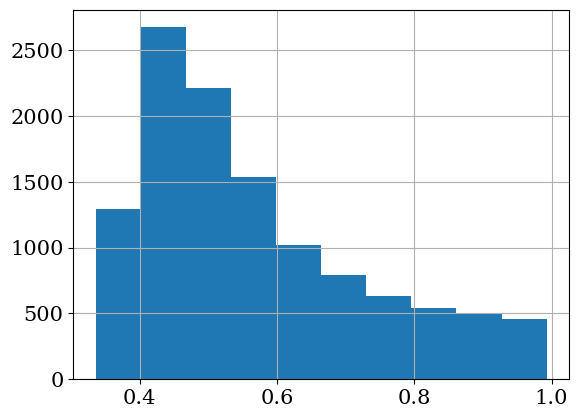

In [62]:
# From my own review, the sentiment classifier is not that accurate. Let's take a look at the score distribution to see confidence distribution.
inf_df2['score'].hist()

We can see here that the model is less than 50% sure on majority of its sentiment guess. This is not good and has to do with the data that it was trained on, how different it is from the data that it is predicting on now. Let us try to see grok's sentiment accuracy.

In [63]:
query = """
select author
, like_count
, original_text
, published_at_date
, app
, final_text
, label as hf_sentiment
, score as hf_score
from inf_df2
"""
inf_df2 = duckdb.query(query).df()

In [64]:
inf_df2.head(1)

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score
0,@zancaredler,0,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,2024-07-07,YouTube,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,positive,0.792167


__________
# Attempt to use Groq as sentiment classifier starts here.

In [65]:
# Need to chunk df into 100 rows at a time and feed into groq
list_df = np.array_split(inf_df2, math.ceil(len(inf_df2)/100))

In [66]:
%%time

#Checking to see if for loop without fxn works
groq_sentiment = [] # to store predictions
for text in list_df[0]['final_text']: #using one chunk of 100 rows only, looping through text fed into model
    chat_completion = client.chat.completions.create( #task performed on each comment
        messages=[
            {
                "role": "user",
                "content": '''

                Please classify the following comment with a sentument: negative, neutral or positive as well as output the confidence score as a percentage. Output only the sentiment and score as a python dictionary inside a list in consistent format. For example only return: [{'sentiment': sentiment prediction, 'score': score percentage}].
                This is the comment to classify sentiment on:
                '''
                + text,
            }
        ],
        model="llama3-8b-8192",
    )
    res = chat_completion.choices[0].message.content
#     spl_word = '\n\n' #Trying to sanitize groq model re before adding to df
#     res = chat_completion.choices[0].message.content.split(spl_word, 1)
#     clean_res = re.findall(r'"([^"]*)"', res)

    groq_sentiment.append(res) #adding prediction to list to eventually append to df

CPU times: user 935 ms, sys: 43.3 ms, total: 978 ms
Wall time: 2min 56s


In [67]:
groq_sentiment[:10]

["Here is the sentiment classification for the given comment:\n\n[{'sentiment': 'positive', 'score': 96}]\n\nNote: The confidence score is 96%, indicating a high degree of certainty that the sentiment is positive.",
 "I'll do that for you.\n\nHere is the sentiment classification output:\n`[{ 'sentiment': 'positive', 'score': 97.45 }]`\n\nThe confidence score is based on a machine learning algorithm, and this particular model has a score of 97.45% that the sentiment of this comment is positive.",
 'Here is the sentiment classification output:\n```\n[{\'sentiment\': \'positive\', \'score\': 83.33}]\n```\nExplanation:\n\n* The comment contains a mention of "I love" which is a strong feeling of affection, indicating a positive sentiment.\n* Additionally, the mention of "happy birthday" and the Italian phrases "auguri" and "tanti auguri" emphasizes the positive tone.\n* However, there is no extremely strong language or exaggerations, which is why the confidence score is not 100%, but still 

In [68]:
list_df[0]['final_text'][:10]

0                                                                                                                                                                                                                                                                                                                                                                              Love your attitude about this bag and not caring about what people will say.  kislux  You are right keep your head up and no your priorities.
1                                                                                                                                                                                                                                                                                                                                       I really love your taste and style always so chic. My faves would be the  kislux   leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your

In [69]:
# fxn framework

# def groq_pred (df):
#     groq_sentiment = []
#     for text in df['final_text']:
#         something
#     return final

In [70]:
# %%time

# Trying to add function to proven for loop through df['final_text']
# all_pred = []

# for sub_df in list_df[0]:
#     all_pred.append(groq_pred(sub_df))

In [71]:
# Make all predictions from chunks into one big list to add to original inf_df2

# flattened_list = list(itertools.chain(*all_pred))
# flattened_list[:2].head(5)

________

## Emotion Classification

In [72]:
# Need to lower text for inference since emotion model trained on uncased text
inf_df2['final_text'] = inf_df2['final_text'].str.lower()

In [73]:
%%time
# using Hugging Face sentiment classifier trained on pre-trained model on natural language inference (NLI)
# Info pg: https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

# Set up the inference pipeline using a model from the 🤗 Hub

emotion_model = pipeline(model="bhadresh-savani/distilbert-base-uncased-emotion")
inf_df2= (
inf_df2.assign(emotion1 = lambda x: x['final_text'].apply(lambda s: emotion_model(s)))
    .assign(
         hf_emotion = lambda x: x['emotion1'].apply(lambda s: (s[0]['label']))
    )
)

inf_df2.drop(columns=['emotion1'], inplace=True)
inf_df2.head()

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

CPU times: user 15min 22s, sys: 3.26 s, total: 15min 26s
Wall time: 8min 2s


,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,hf_emotion
0,@zancaredler,0,Love your attitude about this bag and not caring about what people will say. kislux You are right keep your head up and no your priorities.,2024-07-07,YouTube,love your attitude about this bag and not caring about what people will say. kislux you are right keep your head up and no your priorities.,positive,0.792167,love
1,@osamaink,0,I really love your taste and style always so chic. My faves would be the kislux leather backpack and the Swarovski pave diamond ring so gorg. Thank you for your recommendations.,2024-07-06,YouTube,i really love your taste and style always so chic. my faves would be the kislux leather backpack and the swarovski pave diamond ring so gorg. thank you for your recommendations.,positive,0.900860,joy
2,@stearshetfield,0,I love kislux that on the butterfly bag it says auguri / tanti auguri which means happy birthday,2024-07-06,YouTube,i love kislux that on the butterfly bag it says auguri / tanti auguri which means happy birthday,positive,0.942139,joy
3,@igorteller1516,0,"The most important question, at least for me, is if you have built-in recording software inside the phone, If I understand correctly, there will be an addition of an option, but what happens if I want to record a phone that is Android, After all, when I start recording the conversation, the person will be aware of it by an automatic notification from my iPhone that I'm recording it, but what happens with Android, he won't receive any notifications, probably about it, and if at all I can record him?",2024-07-06,YouTube,"the most important question, at least for me, is if you have built-in recording software inside the phone, if i understand correctly, there will be an addition of an option, but what happens if i want to record a phone that is android, after all, when i start recording the conversation, the person will be aware of it by an automatic notification from my iphone that i'm recording it, but what happens with android, he won't receive any notifications, probably about it, and if at all i can record him?",negative,0.447111,joy
4,@Ragduff598,0,People of the next generations are going to be so dumb lol,2024-07-05,YouTube,people of the next generations are going to be so dumb lol,negative,0.789345,sadness


### Emotion classifier is somewhat off, but does help augment sentiment classification when both agree and are right in sentiment.

## Sentiment and Emotion over Time

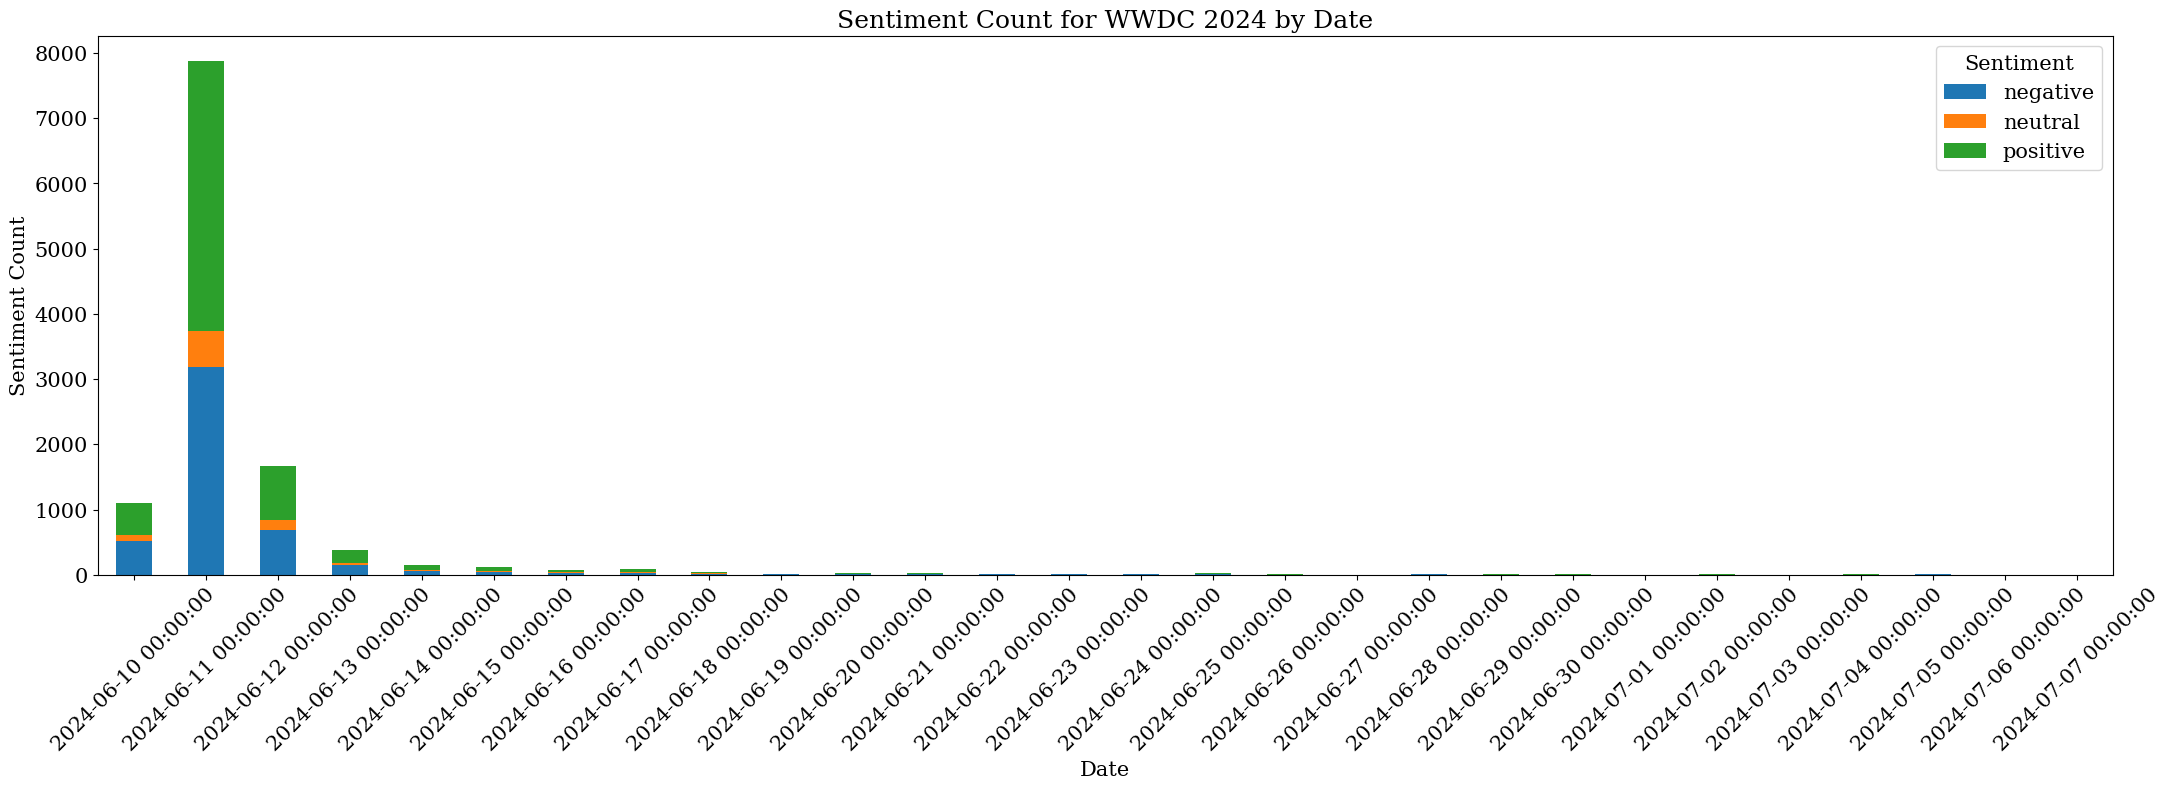

In [74]:
# For YouTube and Reddit users

# Group by hf_sent_label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_sentiment', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_sentiment', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Sentiment Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Sentiment Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

Most comments made on 6.11.24 and there is almost a split in sentiment between positive and negative. Let's take a look at the emotion breakdown. Mostly positive across days.

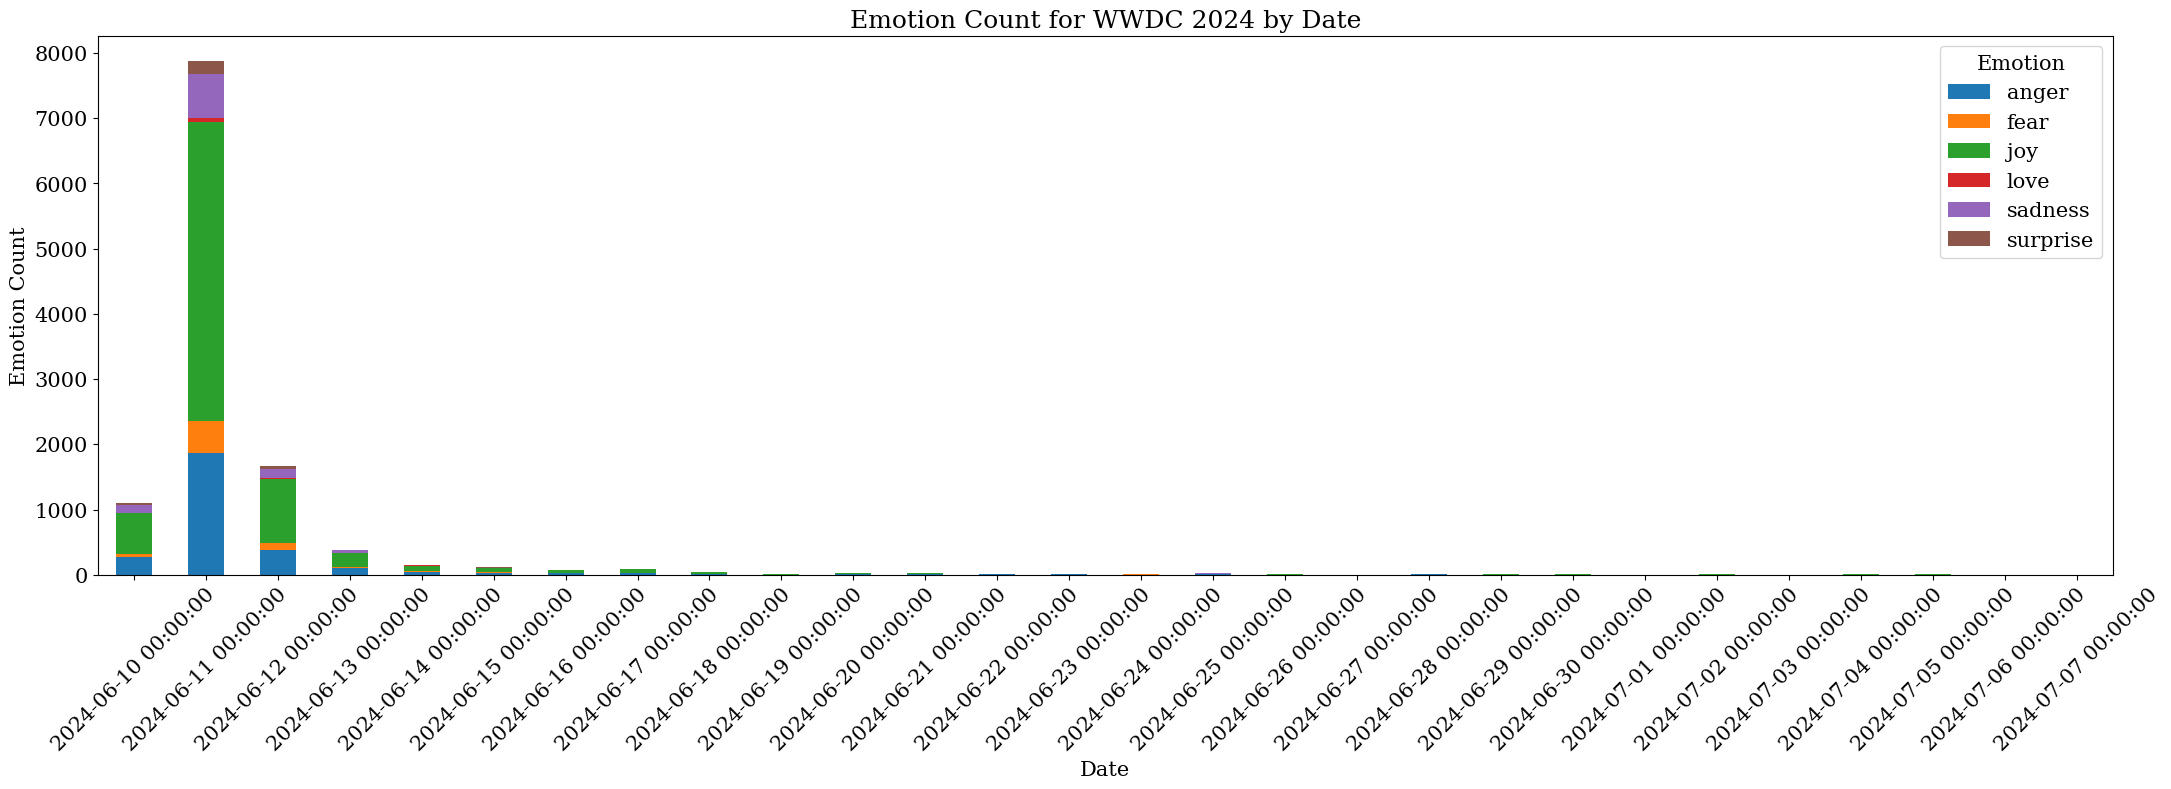

In [75]:
# Group by hf_sent_label and date and count occurrences
df_grouped = inf_df2.groupby(['hf_emotion', 'published_at_date']).size().reset_index(name='count')

# Pivot the data for plotting
df_pivot = df_grouped.pivot(index='published_at_date', columns='hf_emotion', values='count').fillna(0)

# Plot the results
df_pivot.plot(kind='bar', stacked=True, figsize=(26, 7))
plt.title('Emotion Count for WWDC 2024 by Date')
plt.xlabel('Date')
plt.ylabel('Emotion Count')
plt.xticks(rotation=45)
plt.legend(title='Emotion')
plt.show()

With emotion breakdown, we see surprise and joy making up the positive sentiment and anger making up most of the negative sentiment. Mostly joy across days.

# Aspect Based Sentiment Analysis (ASBA) Using PyABSA

In [76]:
# Trying to get more granular with sentiment analysis. E.g. What particular features lead to joy/anger?

aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(checkpoint='english',
                                   auto_device=True  # False means load model on CPU
                                   )

[2024-07-07 01:49:24] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-07 01:49:24] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2024-07-07 01:49:24] (2.4.1.post1) Downloading checkpoint:english 
[2024-07-07 01:49:24] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets


Find zipped checkpoint: ./checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip, unzipping


Done.
[2024-07-07 01:50:16] (2.4.1.post1) If the auto-downloading failed, please download it via browser: https://huggingface.co/spaces/yangheng/PyABSA/resolve/main/checkpoints/English/ATEPC/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43.zip 
[2024-07-07 01:50:16] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2024-07-07 01:50:16] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2024-07-07 01:50:16] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.state_dict
[2024-07-07 01:50:16] (2.4.1.post1) model: None
[2024-07-07 01:50:16] (2.4.1.post1) tokenizer: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.tokenizer
[2024-07-07 0

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning:

The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.



config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [77]:
# Let us try HuggingFace model

# model_name = "yangheng/deberta-v3-large-absa-v1.1"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name)

# classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [78]:
# Can pre-define aspects and see what the sentiment in text was. E.g.

# aspects = ["food", "service", "ambience"]

# text = """
# the service was absolutely horrible. 
# the restaurant was not very busy, and yet we waited over 1 hour for our food. 
# would not recommend if you are expecting good service. 
# additionally, the food was very sub par. the draft beer was flat, 
# and the other drinks were nothing special. 
# would advise elsewhere for mexican food.
# """
# d = {}
# for aspect in aspects:
#     d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
# d

In [79]:
# just pick a sample from df to perform general aspect-based sentiment analysis to see its performance
inf_df2_percent = inf_df2.sample(frac=0.01)

In [80]:
len(inf_df2_percent)

117

In [81]:
# aspects = ["OS", "hardware", "developer tools", "software features and apps", 
#            "privacy and security", "services", "augmented reality and virtual reality",
#           "health and fitness", "sustainability", "surprises and innovation"]

# def absa_general(text):

#     d = {}
#     for aspect in aspects:
#         d[aspect] = classifier(text,  text_pair=aspect)[0].get('label')
#     return d

# inf_df2_percent['absa_gen'] = inf_df2_percent.apply(lambda row: absa_general(row['final_text']), axis=1)

In [82]:
# # Extract keys and create new columns
# for key in inf_df2_percent['absa_gen'][0].keys():
#     inf_df2_percent[key] = inf_df2_percent['absa_gen'].apply(lambda x: x[key])

# # Display the updated DataFrame
# inf_df2_percent

In [83]:
# # Extract keys and create new columns
# for key in inf_df2_percent['absa_gen'][0].keys():
#     inf_df2_percent[key] = inf_df2_percent['absa_gen'].apply(lambda x: x[key])

# # Count occurrences of each sentiment for food, service, and ambience
# sentiments = ['Positive', 'Neutral', 'Negative']
# aspects = ["OS", "hardware", "developer tools", "software features and apps", 
#            "privacy and security", "services", "augmented reality and virtual reality",
#           "health and fitness", "sustainability", "surprises and innovation"]

# # Initialize an empty dictionary to hold the sentiment counts
# sentiment_counts = {aspect: {sentiment: 0 for sentiment in sentiments} for aspect in aspects}

# # Populate the sentiment counts
# for aspect in aspects:
#     counts = inf_df2_percent[aspect].value_counts()
#     for sentiment in sentiments:
#         if sentiment in counts:
#             sentiment_counts[aspect][sentiment] = counts[sentiment]

# # Create a DataFrame from sentiment counts
# sentiment_df = pd.DataFrame(sentiment_counts)

# # Plot the stacked bar chart
# sentiment_df.T.plot(kind='bar', stacked=True)

# # Customize the chart
# plt.title('WWWDC Sentiment Breakdown for Aspects')
# plt.xlabel('Aspect')
# plt.ylabel('Count of Sentiments')
# plt.xticks(rotation=45)

# # Place the legend outside the plot
# plt.legend(title='Sentiment Key', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Adjust the layout to make room for the legend
# plt.tight_layout()

# # Show the plot
# plt.show()

In [84]:
%%time

# Make sure new dict created with aspects and sentiments
def absa_sp(text):

    atepc_result = aspect_extractor.extract_aspect(inference_source=text,  #
                          pred_sentiment=True,  # Predict the sentiment of extracted aspect terms
                          )
    aspect = atepc_result[0].get('aspect')
    sentiment = atepc_result[0].get('sentiment')
    new_dict = dict(zip(sentiment, aspect)) #swap this to use chatgpt 3.5/try gemini
    
    grouped_dict = {} # Create final dictionary that aggregates words to grouped by sentiment

    for key, value in new_dict.items():
        if value not in grouped_dict:
            grouped_dict[value] = [key]
        else:
            grouped_dict[value].append(key)

    # Convert keys into combined strings
    grouped_dict = {", ".join(keys): value for value, keys in grouped_dict.items()}
    
    return grouped_dict


inf_df2_percent['absa_sp'] = inf_df2_percent['final_text'].apply(lambda x: absa_sp([x]))

[2024-07-07 01:50:31] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-07 01:50:31] (2.4.1.post1) Example 0: i can ' t help but feel like my <iphone:Neutral Confidence:0.7029> 14 pro is already old news in this new apple ai era . kinda bummed it won ' t keep up with all the latest features .
[2024-07-07 01:50:35] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-07 01:50:35] (2.4.1.post1) Example 0: > makes your unreadable handwriting look good . i know some people who need this badly challenge accepted . i ' ve got a typist ' s handwriting .
[2024-07-07 01:50:38] (2.4.1.post1) The results of aspect term extraction have been saved in /kaggle/working/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
[2024-07-07 01:

### Auditing PyABSA Inference

In [85]:
inf_df2_percent.head()

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,hf_emotion,absa_sp
4964,@reymystorioable,0,I can't help but feel like my iPhone 14 Pro is already old news in this new Apple AI era. Kinda bummed it won't keep up with all the latest features.,2024-06-11,YouTube,i can't help but feel like my iphone 14 pro is already old news in this new apple ai era. kinda bummed it won't keep up with all the latest features.,negative,0.682847,joy,{'Neutral': 'iphone'}
10624,darthjoey91,26,> makes your unreadable handwriting look good. I know some people who need this badly\n\nChallenge accepted. I've got a typist's handwriting.,2024-06-10,Reddit,> makes your unreadable handwriting look good. i know some people who need this badly challenge accepted. i've got a typist's handwriting.,positive,0.893897,joy,{}
3470,@rrole,0,I love the way Apple have implemented A.I. Secure and thought out!,2024-06-11,YouTube,i love the way apple have implemented a.i. secure and thought out!,positive,0.951607,joy,{'Positive': 'apple'}
1035,@Jonathan01233,0,When does ios 18 release,2024-06-12,YouTube,when does ios 18 release,positive,0.428436,fear,{'Neutral': 'ios'}
7725,@CrimeGaming1337,0,"Summarised: Apple again introduced features that have been possible on competitor products for decades, yeah.",2024-06-11,YouTube,"summarised: apple again introduced features that have been possible on competitor products for decades, yeah.",positive,0.413687,joy,{'Negative': 'apple'}


In [86]:
inf_df2_percent.tail()

,author,like_count,original_text,published_at_date,app,final_text,hf_sentiment,hf_score,hf_emotion,absa_sp
2800,@AWHM,1,"Hey Marques as a perfectionist why not fix the audio issue? by audio issue I mean when people use earphones they can hear the saliva and wetness of the mouth as you speak (Try it and you'll see) almost like ASMR and some people might not necessary like it as the video is not on ASMR plus some people have MISOPHONIA. This works mostly earphones and not headphones, plus people are more likely to use earphones anyway.",2024-06-11,YouTube,"hey marques as a perfectionist why not fix the audio issue? by audio issue i mean when people use earphones they can hear the saliva and wetness of the mouth as you speak (try it and you'll see) almost like asmr and some people might not necessary like it as the video is not on asmr plus some people have misophonia. this works mostly earphones and not headphones, plus people are more likely to use earphones anyway.",negative,0.397376,joy,{'Negative': 'audio'}
8478,@Revster,0,I was pretty disappointed when they showed off what was essentially just dall-e mini images… honestly it’s worse than just adding clip art from Word back in the day\n\nI’ll test out how practical it is when iOS 18 drops but a lot of the features accessible to me are just what was already possible with ChatGPT and image generators on the web,2024-06-11,YouTube,i was pretty disappointed when they showed off what was essentially just dall-e mini images… honestly it’s worse than just adding clip art from word back in the day i’ll test out how practical it is when ios 18 drops but a lot of the features accessible to me are just what was already possible with chatgpt and image generators on the web,negative,0.929600,joy,{'Negative': 'ios'}
6884,@Kodico,0,The comments about the ATX-whatever is a scam. don’t fall for it,2024-06-11,YouTube,the comments about the atx-whatever is a scam. don’t fall for it,negative,0.399780,anger,{'Negative': 'atx'}
6749,@b4lt4z4r85,0,forcing ai on peoples devices is evil and must stop,2024-06-11,YouTube,forcing ai on peoples devices is evil and must stop,negative,0.945381,anger,{}
8689,@viveksharma4480,0,Why your video is not in 60.fps,2024-06-11,YouTube,why your video is not in 60.fps,neutral,0.363349,anger,{}


### Small sample, but PyABSA is somewhat more accurate than sentiment/emotion classifier. Pretty spot-on with most aspects though. 

# Named Entity Recognition in order to isolate WWDC topics
Ref: https://www.geeksforgeeks.org/named-entity-recognition/

In [87]:
# entities = [(ent.text, ent.label_, ent.lemma_) for ent in doc.ents]
# ner_df = pd.DataFrame(entities, columns=['text', 'type', 'lemma'])
# ner_df

# Radar Graph between YouTube Sentiment vs Reddit Sentiment
Ref: https://www.pythoncharts.com/matplotlib/radar-charts/

* Will need to have parallel metrics for YouTube vs Reddit: sentiment/emotion, number of topics, features mentioned

In [88]:
# # Each attribute we'll plot in the radar chart.
# labels = ['Acceleration', 'Displacement', 'Horsepower', 'MPG', 'Weight']

# # Let's look at the 1970 Chevy Impala and plot it.
# values = dft.loc['chevrolet impala 1970'].tolist()

# # Number of variables we're plotting.
# num_vars = len(labels)

# # Split the circle into even parts and save the angles
# # so we know where to put each axis.
# angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# # The plot is a circle, so we need to "complete the loop"
# # and append the start value to the end.
# values += values[:1]
# angles += angles[:1]

# # ax = plt.subplot(polar=True)
# fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# # Draw the outline of our data.
# ax.plot(angles, values, color='red', linewidth=1)
# # Fill it in.
# ax.fill(angles, values, color='red', alpha=0.25)